# TITLE: Intro to Robotics Exercise 3
# AUTHORS: Rhys Miller & Samuel Law

In [36]:
%reset -f

In [37]:
%matplotlib inline

In [38]:
import sympy as sm
import sympy.physics.mechanics as me
import matplotlib.pyplot as plt
from IPython.display import Latex, display
from mathtools.root_locus import *
from mathtools.symbolic import sym2poly
from numpy import linspace, array, pi, sqrt, polyfit, vstack, sign
from scipy.integrate import RK45

In [39]:
def show(eq_lhs: str, eq_rhs: str):
    eq = f"${eq_lhs} = {eq_rhs}$"
    return display(Latex(eq))

## Kinematics

In [40]:
# create the inertial frame
N = me.ReferenceFrame("N")
pN = me.Point("pN")
pN.set_vel(N, 0)

In [41]:
# define the constant g
g, gear_ratio = sm.symbols("g, gear_ratio")

In [42]:
# declare independent variables
q1, u1 = me.dynamicsymbols("q1, u1")
q1d, u1d = me.dynamicsymbols("q1, u1", 1)
q1dd = me.dynamicsymbols("q1", 2)

In [43]:
# declare dependent variables
q0 = -q1*gear_ratio
q0d = -q1d*gear_ratio
q0dd = -q1dd*gear_ratio
u0 = -u1*gear_ratio

In [44]:
# create the bodies
bodyA = me.Body(
    name = "bodyA",
    frame = N.orientnew("A", "axis", (q0,N.z)),
)
bodyB = me.Body(
    name = "bodyB",
    frame = N.orientnew("B", "axis", (q1, N.z))
)

In [45]:
# define the motor shaft diameter
bodyA.D = sm.symbols("D_A")
# define the link length to bodyB COM
bodyB.L = sm.symbols("L_B")

In [46]:
# define positions of the COMs
bodyA.masscenter = pN.locatenew("pA", 0)
bodyB.masscenter = pN.locatenew("pB", bodyB.L*bodyB.frame.x)

In [47]:
# define the velocities
bodyA.masscenter.set_vel(N, bodyA.masscenter.pos_from(pN).dt(N))
bodyB.masscenter.set_vel(N, bodyB.masscenter.pos_from(pN).dt(N))

In [48]:
# define accelerations
bodyA.masscenter.set_acc(N, bodyA.masscenter.vel(N).dt(N))
bodyB.masscenter.set_acc(N, bodyB.masscenter.vel(N).dt(N))

## Dynamics

In [49]:
# apply kanes method
KM = me.KanesMethod(
    frame = N,
    q_ind = [q1],
    u_ind = [u1],
    kd_eqs = [q1d - u1]
)

In [50]:
# create a list of the bodies
bodies = [bodyA, bodyB]

In [51]:
# define the applied loads
tau1 = sm.symbols("tau_1")
loads = [
    # point/frame, force.moment
    (bodyA.masscenter, -g*bodyA.mass*N.z),
    (bodyB.masscenter, -g*bodyB.mass*N.z),
    (bodyB.frame, tau1*bodyA.frame.z)
]

In [52]:
# apply the loads and bodies to the KM object
KM.kanes_equations(bodies, loads);

In [53]:
# extract the mass and force matrix
MM = KM.mass_matrix
FM = KM.forcing

In [54]:
# seperate the force out into driving and non-driving
A, b = sm.linear_eq_to_matrix(FM, tau1)
TM = A.inv()*(MM*sm.Matrix([q1dd]) + b)
show("TM", me.vlatex(TM))

<IPython.core.display.Latex object>

In [55]:
# create a dict to hold numeric values
vals = {
    # lengths
    bodyB.L: 0.02162775,         # m
    bodyB.mass:   0.00728203,    # kg 
    "bodyB_izz":  6.39e-06,      # kg*m^2
    "bodyA_izz":  3.3e-07,       # kg*m^2
    gear_ratio: 144,             # a.u
}

# Joint Space Simulation

The following block diagram requires several assumptions to model accurately
1. The signal is constrained to between 0 and 5 volts
2. The motor and q_actual have a linear relationship
3. Due to nonlinear behavior that limits the voltage 12V, <br> modeling in time domain is easier.
4. The delay between the control signal and the motor signal is neglegable

In [56]:
# create variables for desired output
q1_desired, q1d_desired = sm.symbols("q1_desired, q1d_desired")

# creatue variables for current output
q1_current, q1d_current = sm.symbols("q1_current, q1d_current")

In [57]:
# create the controller signal
Kp, Kv = sm.symbols("Kp, Kv")
u = (Kv*(q1d_desired - q1d_current)) + (Kp*(q1_desired - q1_current))
u

Kp*(-q1_current + q1_desired) + Kv*(-q1d_current + q1d_desired)

In [58]:
# create the constant C1
C1, *_ = TM.subs(vals)/q1dd  # the term that describes the 
C1

0.00685267623922198

In [59]:
# create the constant C2
R = 7.5        # ohms
kt = 0.891514  # Nm/amp, from manufacture's page
C2 = R/kt
C2

8.412655325659497

### SIMULATION CONTROLS

In [60]:
# calculate max Kp value
V_min = 3                   # voltage required for motor to actually move based on experimentation
CPR = 1000                  # counts per revolution
rad_min = 2*pi/1000         # smallest detectable error 
Kp_max = V_min/(rad_min*2)  # the 2 allows it to be +- one count from desired position
Kp_max

238.732414637843

In [61]:
# create all the callables
simulation_parameters = {
    q1_desired: 3,
    q1d_desired: 0,
    Kp: int(Kp_max),
    Kv: sqrt(477*8),
}

In [62]:
# create controller callable
controller_signal = sm.lambdify([q1_current, q1d_current], u.subs(simulation_parameters), modules="numpy")
controller_signal(12, 0)

-2142.0

In [63]:
# create motor torque callable to emulate q1dd
rpms = (0, 40, 50)
taus = (0.980665, 0.4413, 0)
slope1, intercept1 = np.polyfit(rpms[0:2], taus[0:2], 1)
slope2, intercept2 = np.polyfit(rpms[1:], taus[1:], 1)
def tau_motor(x):
    if rpms[0] <= x <= rpms[1]:
        return (slope1*x) + intercept1
    elif rpms[1] <= x <= rpms[2]:
        return (slope2*x) + intercept2
    else:
        return 0

x1 = q1,    x1d = q1d <br>
x2 = q1d,   x2d = q1dd <br>

In [64]:
# create the RK45 simulation
def model(t, x):    
    # unpack the vector
    q1, q1d = x
    
    # calculate the controller signal
    u = controller_signal(q1, q1d)
    
    # get globals
    global C1
    
    # calculate tau
    tau_desired = abs(u*C1)    
    
    # calculate RPM
    RPM = abs(q1d*30/pi)
        
    # check if desired torque is in the opposite direction of RPM
    if sign(u) != sign(q1d):
        tau_max = tau_motor(0)
    else:
        tau_max = tau_motor(RPM)
    
    # determine value of tau
    tau = tau_desired if tau_desired < tau_max else tau_max
        
    # calculate the acceleration due to torque
    q1dd = tau*sign(u)/C1
    
    # return the xdots
    x1d = q1d
    x2d = q1dd
    
    return (x1d, x2d)

# create the initial conditions
simulator = RK45(model, 0, [0, 0], 3.5, max_step=0.05)
results = array([0, 0])
while True:
    try:
        simulator.step()
    except:
        break
    else:
        results = vstack([results, (simulator.t, simulator.y[0])])

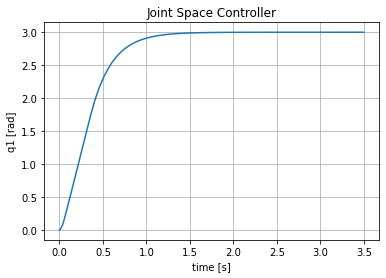

In [65]:
plt.plot(results[:, 0], results[:, 1])
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("q1 [rad]")
plt.title("Joint Space Controller");

In [66]:
print(results[-50:])

[[1.0578025  2.92939171]
 [1.1078025  2.94256167]
 [1.1578025  2.95327514]
 [1.2078025  2.96199033]
 [1.2578025  2.96907995]
 [1.3078025  2.9748472 ]
 [1.3578025  2.97953874]
 [1.4078025  2.9833552 ]
 [1.4578025  2.98645981]
 [1.5078025  2.98898535]
 [1.5578025  2.99103982]
 [1.6078025  2.99271108]
 [1.6578025  2.99407062]
 [1.7078025  2.99517658]
 [1.7578025  2.99607625]
 [1.8078025  2.99680811]
 [1.8578025  2.99740347]
 [1.9078025  2.99788778]
 [1.9578025  2.99828175]
 [2.0078025  2.99860224]
 [2.0578025  2.99886295]
 [2.1078025  2.99907504]
 [2.1578025  2.99924756]
 [2.2078025  2.99938791]
 [2.2578025  2.99950208]
 [2.3078025  2.99959495]
 [2.3578025  2.9996705 ]
 [2.4078025  2.99973196]
 [2.4578025  2.99978195]
 [2.5078025  2.99982262]
 [2.5578025  2.99985571]
 [2.6078025  2.99988262]
 [2.6578025  2.99990452]
 [2.7078025  2.99992233]
 [2.7578025  2.99993681]
 [2.8078025  2.9999486 ]
 [2.8578025  2.99995819]
 [2.9078025  2.99996599]
 [2.9578025  2.99997233]
 [3.0078025  2.99997749]


# PD Controller Simulation

The PD controller is close to the joint space controller, however, the <br> 
PD controller does not feed into a constant C1 in order to account for mass <br>
properties when computing the desired torque. 

In [32]:
# create all the callables
simulation_parameters = {
    q1_desired: 12,
    q1d_desired: 0,
    Kp: int(Kp_max),
    Kv: 100
}

In [33]:
# create controller callable
controller_signal = sm.lambdify([q1_current, q1d_current], u.subs(simulation_parameters), modules="numpy")
controller_signal(12, 0)

0

In [34]:
# create the RK45 simulation
def model(t, x):    
    # unpack the vector
    q1, q1d = x
    
    # calculate the controller signal
    u = controller_signal(q1, q1d)
    
    # calculate tau
    tau_desired = abs(u)    
    
    # calculate RPM
    RPM = abs(q1d*30/pi)
        
    # check if desired torque is in the opposite direction of RPM
    if sign(u) != sign(q1d):
        tau_max = tau_motor(0)
    else:
        tau_max = tau_motor(RPM)
    
    # determine value of tau
    tau = tau_desired if tau_desired < tau_max else tau_max
    
    # get globals
    global C1
        
    # calculate the acceleration due to torque
    q1dd = tau*sign(u)/C1
    
    # return the xdots
    x1d = q1d
    x2d = q1dd
    
    return (x1d, x2d)

# create the initial conditions
simulator = RK45(model, 0, [0, 0], 3, max_step=0.05)
results = array([0, 0])
while True:
    try:
        simulator.step()
    except:
        break
    else:
        results = vstack([results, (simulator.t, simulator.y[0])])

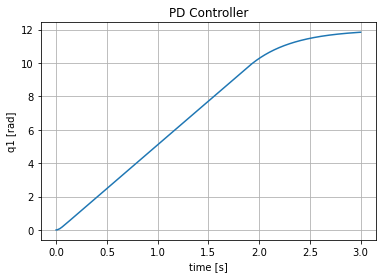

In [35]:
plt.plot(results[:, 0], results[:, 1])
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("q1 [rad]")
plt.title("PD Controller");